In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ss

In [2]:
from nltk.corpus import stopwords
import regex as re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB, ComplementNB
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning);

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

In [84]:
from random import choices

In [4]:
df = pd.read_csv('../data/cleaned_02_ii.csv')
print(df.shape)
df.head()

(39565, 60)


,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,hate_rank,capital_sentance,cleaned_text,wc_cleaned_text
0,0,White people are trash.,0.46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,white peopl are trash,4
1,0,"You've caught the big gay, it's known to be ai...",0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,you ve caught the big gay it s known to be air...,14
2,0,"I'm not saying you said that, I'm just saying ...",-1.29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,i m not say you said that i m just say that if...,75
3,0,Donald Trump. Yeet myself off a building onto ...,-0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,donald trump yeet myself off a build onto a ga...,20
4,0,Fabrice Fabrice is ostensibly black or black/l...,-2.84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,fabric fabric is ostens black or black latino ...,19


In [188]:
# h wait, let me copy over the fllowing:
# hate_speech_score - continuous hate speech measure, where higher = more hateful and lower = less hateful. 
# > 0.5 is approximately hate speech, < -1 is counter or supportive speech, and -1 to +0.5 is neutral or ambiguous.

# ...Misread this - ambiguous also goes below...

lower_limit, upper_limit = .5, 2
df['hate_rank'] = [2 if i > upper_limit
                  else 1 if i > lower_limit else 0
                  for i in df['hate_speech_score']]
df['hate_rank'].value_counts(normalize=True)

hate_rank
0    0.738304
1    0.208973
2    0.052723
Name: proportion, dtype: float64

# Round I of modeling!

Reminder again that our target is somewhat ambiguous, tweaks to be adjusted to the 'cleaned text' among other things before the anticipated 'fun' of adding in other factors such as platform and target.

In [6]:
X = df['cleaned_text']
y = df['hate_rank']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25, #Given the size we'll start with this, a bit larger than what I'd usually do
                                                    random_state = 26, #I like this number
                                                    stratify=y) #Particularly important in this case with 3 targets

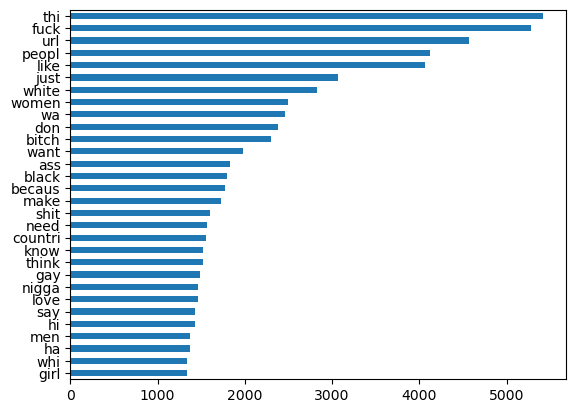

In [22]:
#For kicks, to get a bit of a taste of the upcoming data. 
cvec_ex = CountVectorizer(stop_words='english')
X_train_cvec_ex = cvec_ex.fit_transform(X_train)
X_train_ex = pd.DataFrame(X_train_cvec_ex.todense(),
                          columns=cvec_ex.get_feature_names_out())

X_train_ex.sum().sort_values().tail(30).plot(kind="barh");

Unsurprising, the 'f' word is high up there being the second mst common (only behind 'this'). Likely its presence, along with any other similar word, is more indicative of hate speech.

Other interesting words (tokens) include: just, b****, a**, white, black, woman, countri, n****, gay, men, and girl. Of particular interst to me is 'just'. Albeit it is a stopword, however

In [16]:
# stopwords.words().index('just')

3083

In [18]:
X_train_ex.shape[1]#Ww, quite a lot of words...

28445

In [ ]:
# pipe = Pipeline([
#     ('cvec', CountVectorizer(lowercase=False))
#     ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial'))
# ])

# pipe_params = {'cvec__min_df' : [.05, .00]
#                ,'cvec__max_df' : [.95, 1.00]
#                ,'cvec__ngram_range' : [(1, 1)]
#                ,'cvec__max_features' : [2000, 5000]
#                ,'cvec__stop_words' : ['english', None]
#               }

# gs = GridSearchCV(pipe,
#                   param_grid=pipe_params,
#                   cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

# #Output:
# 0.7661510464058234 0.7093610998786899
# 0.7039399584704426
# {'cvec__max_df': 0.95, 'cvec__max_features': 2000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}

Above is a copy of the first iteration I ran, and will serve as a general template describing my thought process for the rest of this project:

Well, we got a nice bit of overfitting and overall not the greatest accuracy. Recall how we're
dealng with multi-class classification and would need to properly address the metrics - as now sensitivity seems a bit more abstruse.

Regardless, I'll keep the metrics as overall accuracy for now, as I want to do a lot better than a mere 70%.

Anyways, regarding going forward with hyper-parameters: Notice the selection of specific feature and explore that trend more. Ex. we chose .95 for max df when we had two options: .95 and 1.00. Likely let us explor if that .95 preference is even lower (such as next trying maybe .925) or a bit higher (such as .975) yet not as big as the original alternative of 1.00.

Only other parameter I'll call attention to is rejection of using English stopwords. Among other theories, perhaps related to the trend we noticed of more positive posts often being longer in length.

In [56]:
# trial_model = gs.best_estimator_
# trial_model.fit(X_train,y_train)
# print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

# preds = gs.predict(X_test)
# preds_prob = gs.predict_proba(X_test)
# hyper_pred_comparer = pd.DataFrame({
#     'cleaned_text':X_test
#     ,'actual':y_test
#     ,'pred':preds
#     ,'p_0':preds_prob[:,0]
#     ,'p_1':preds_prob[:,1]
#     ,'p_2':preds_prob[:,2]
# })

0.7661510464058234 0.7093610998786899


In [57]:
# hyper_misses = hyper_pred_comparer[hyper_pred_comparer['actual']!=hyper_pred_comparer['pred']]
# i = -1

In [59]:
# i += 1
# print(i)
# print(hyper_misses.iloc[i, 1:3])
# print(hyper_misses.iloc[i, 3:6])
# hyper_misses.iloc[i, 0]

1
actual    0
pred      2
Name: 37719, dtype: object
p_0    0.006897
p_1    0.490072
p_2    0.503031
Name: 37719, dtype: object


'non white american pleas relax and don t worri about what crazi trump and hi mental sick support are say becaus thi countri is your and will be onli your soon these ignor pig will disappear soon if you want them to go you are go too'

In [60]:
# print(1)
# print(hyper_misses.iloc[1, 1:3])
# print(hyper_misses.iloc[i, 3:6])
# hyper_misses.iloc[1, 0]
# We'll look at this example (current per the - our model thought it was a 2:

#Yeah, I'm not surprised when it makes references to say many groups AND in a somewhat edgy way.
#Ie 'disappear' 'soon' 'crazi' 'mental/sick',etc.

1
actual    0
pred      2
Name: 37719, dtype: object
p_0    0.006897
p_1    0.490072
p_2    0.503031
Name: 37719, dtype: object


'non white american pleas relax and don t worri about what crazi trump and hi mental sick support are say becaus thi countri is your and will be onli your soon these ignor pig will disappear soon if you want them to go you are go too'

In [66]:
#All right, we got our basic methodology done. It's tuning time!!!!!!
#Think I'm excited?

pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial'))
])

pipe_params = {'cvec__min_df' : [.00]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [1175, 1225, 1200]
               ,'cvec__stop_words' : [None]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)
gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7487952010245004 0.7071370804690659
0.7110505535617999
{'cvec__max_df': 0.95, 'cvec__max_features': 1200, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}


In [67]:
#Hmm, it looks like this is the best we're going to get... a mere 70%... For now we'll take it.
#Note, that even with the cvec we can hopefully improve accuracy via the addition of the other featues
#such as word count, type of discrimination, etc.

In [72]:
#Continuing with Tiffany:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial'))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [2100, 2150, 2125]
               ,'tvec__stop_words' : [None]
               }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7571529673440501 0.7175495349777598
0.7184985244882702
{'tvec__max_df': 0.95, 'tvec__max_features': 2125, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [ ]:
#Gah, honestly also lackluster. A bit better albit, now being over 71%. #I'll still continue a bt
#more in this brutish approach.

In [76]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [4500, 4600, 4400]
               ,'cvec__stop_words' : ['english']
               ,'mnb__alpha': [1.0]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7473123715161931 0.7098665588354226
0.7110843655384744
{'cvec__max_df': 0.95, 'cvec__max_features': 4500, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'mnb__alpha': 1.0}


In [ ]:
#Might as well try also with Tiffany, especially when I'm just grasping for at least an itial
#guess model to be above80%...

In [80]:
#TBD if we'll do pipes for both cvec and Tiffany, but we have to at least try the others:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [4500, 4400, 4600]
               ,'tvec__stop_words' : ['english', None]
               ,'mnb__alpha': [.98]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7474134735281233 0.7213910230489284
0.7207563740317886
{'mnb__alpha': 0.98, 'tvec__max_df': 0.95, 'tvec__max_features': 4400, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [88]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('gnb', GaussianNB())
])
pipe_params = {'cvec__min_df' : [.05]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [1750, 1775, 1725]
               ,'cvec__stop_words' : ['english']
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)
#Oh wow, this one did terrible... did I forget a paramter to tune?!?!Seemngly not...

0.5166986823037778 0.5109179134654266
0.5184172712530903
{'cvec__max_df': 0.95, 'cvec__max_features': 1750, 'cvec__min_df': 0.05, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}


In [5]:
# #Unfortunately I was unable to fit this one (perhaps with the parameters) ie it took too long for me to bother...
# pipe = Pipeline([
#     ('cvec', CountVectorizer(lowercase=False))
#     ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
#     ,('canb', CategoricalNB())
# ])
# pipe_params = {'cvec__min_df' : [.0, .05]
#                ,'cvec__max_df' : [.95, 1.0]
#                ,'cvec__ngram_range' : [(1, 1), (1,2)]
#                ,'cvec__max_features' : [2000, 3000, 4000]
#                ,'cvec__stop_words' : ['english', None]
#                ,'canb__alpha': [.95, 1.0]
#               }
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5)

# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

In [10]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('conb', ComplementNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [4400, 4350, 4450]
               ,'cvec__stop_words' : [None]
               ,'conb__alpha': [1.0]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7402015300104472 0.715729882733522
0.7165437560994585
{'conb__alpha': 1.0, 'cvec__max_df': 0.95, 'cvec__max_features': 4400, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}


In [ ]:
#Reminder for the the others... we have to do them this time...

In [12]:
##Also didn't get this one either...
# pipe = Pipeline([
#     ('cvec', CountVectorizer(lowercase=False))
#     ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
#     ,('svc', SVC())
# ])
# pipe_params = {'cvec__min_df' : [.0]
#                ,'cvec__max_df' : [1.0]
#                ,'cvec__ngram_range' : [(1,1), (1,2)]
#                ,'cvec__max_features' : [2000, 4000]
#                ,'cvec__stop_words' : ['english', None]
#                ,'svc__kernel': ['linear']
#                ,'svc__C': [.95, .1]
#               }
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

In [13]:
# #Won't even bother...
# pipe = Pipeline([
#     ('tvec', TfidfVectorizer(lowercase=False))
#     ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
#     ,('svc', SVC())
# ])
# pipe_params = {'tvec__min_df' : [.0]
#                ,'tvec__max_df' : [1.0]
#                ,'tvec__ngram_range' : [(1,2), (1,1)]
#                ,'tvec__max_features' : [2000, 4000]
#                ,'tvec__stop_words' : ['english']
#                ,'svc__kernel': ['linear']
#                ,'svc__C': [.95]
#               }
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

## Re-evaluation

So, this approach cleearly isn't working with bottom line getting accuracies in the mere 70s. Sure, perhaps we should
redefine the borderline of hateful speach, but still...

I'll do at least one redefine before trying something else...

Recall from camp we had a few approaches with underrepresented classes. The fourth was something we'll explore momentarily.

In [15]:
df['hate_speech_score'].describe()

count    39565.000000
mean        -0.943911
std          2.073087
min         -8.340000
25%         -2.330000
50%         -0.700000
75%          0.570000
max          6.300000
Name: hate_speech_score, dtype: float64

In [19]:
df['hate_speech_score'].quantile(.95) #Eh, we'll keep it as is... 

#So, before we go again, I want to run again the 'baseline' logistic regression with a few changes:

2.04

In [47]:
# #Wait, will this even work with a sparse matrix?.... Let me try with weights first...
# ros = RandomOverSampler(random_state=26)
# X_ros, y_ros = ros.fit_resample(X, y)
# X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X
#                                                     ,y
#                                                     ,test_size = 0.25
#                                                     ,random_state = 26
#                                                     ,stratify=y_ros)

In [50]:
X.shape, y.shape

((39565,), (39565,))

In [18]:
# smote = SMOTE(random_state=26)
# X_smote, y_smote = smote.fit_resample(X, y)
# X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X
#                                                     ,y
#                                                     ,test_size = 0.25
#                                                     ,random_state = 26
#                                                     ,stratify=y_smote)

In [69]:
# pipe = Pipeline([
#     ('tvec', TfidfVectorizer(lowercase=False))
#     ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial'))
# ])
# pipe_params = {'tvec__min_df' : [.0]
#                ,'tvec__max_df' : [.95]
#                ,'tvec__ngram_range' : [(1,1)]
#                ,'tvec__max_features' : [2125]
#                ,'tvec__stop_words' : [None]
#                }
# scorer = make_scorer(recall_score, average = None) #Syntax essentially from Gunes of StackExchange
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5
#                  ,scoring=scorer)

# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

In [96]:
# def class_recall(class_location):
#     score = recall_score(y_true, y_pred, average = None)
#     return score[class_location]

In [79]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial', class_weight={0:1,1:1.25,2:4}))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [2125]
               ,'tvec__stop_words' : [None]
               }
scorer = make_scorer(recall_score, average = 'weighted')#Syntax essentially from Gunes of StackExchange
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7942237050517306 0.7551556813586737
0.7548275796468256
{'tvec__max_df': 0.95, 'tvec__max_features': 2125, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [80]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

0.7942237050517306 0.7551556813586737


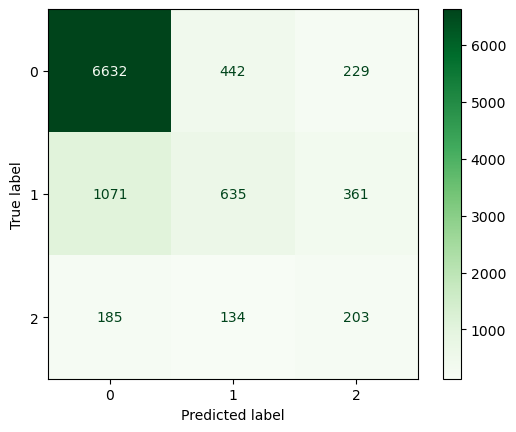

In [81]:
ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [13]:
confusion_matrix(y_test, preds)[2]

array([185, 134, 203], dtype=int64)

In [ ]:
#Hmm, let's finally get the scoring down. We're most interested in category 2; however, per revisioning the problm statement
#likely a focus on one is enough. So, this would basically be correctly identifying the negatives of 0, is tn/tn+fp is specificity
    #Ie specificity of 2s.
#Alt, go back to focusing on the most toxic 2s: tp/tp+fn sensitivity of 2s.

In [83]:
#Hmm, so after the ponderings and wanderings let us go back to our original dataframe, resample 1s and 2s, then run everything anew
df['hate_rank'].value_counts()

hate_rank
0    29211
1     8268
2     2086
Name: count, dtype: int64

In [87]:
(df.shape[0]//3000)+1 #Somewhat arbitrary number, but in short I want to: 
#1) Limit the 0 category
#2) Resample the 1 and 2 category
#14k per group was chosen to be 'as big as the original' yet still being small enough to practically work with.
    #I might change this later, as now group 2 is sooo overused. I'd be comfortable off hand with 6kish, with each post
    #likly being used 3 times each, but an on-average of 7 seems excesive... And, for whatever it matters: The other
    #big project we did with Reddit titles had 1.5kish per group...
#For consistency's sake, I will also sample 0 with replacement.

#Also, I don't think I'll bother to worry aobut original comment id. But we'll see.

14

In [90]:
df_0 = df[df['hate_rank']==0].sample(14_000, replace=True, random_state=26)
df_0.head()

,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,hate_rank,capital_sentance,cleaned_text,wc_cleaned_text
28703,2,@ramprasad_c @kaypeekps75 Media slept for 70 y...,-1.18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ramprasad c kaypeekps75 media slept for 70 yr ...,48
29938,2,WAKE UP AMERICA! This is coming from a Member ...,-1.16,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,wake up america thi is come from a member of c...,49
13426,0,To date: antifa death count 0. How about that ...,-0.45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,to date antifa death count 0 how about that wh...,19
14170,0,stop posting faggot,-0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,stop post faggot,3
34617,3,+amy benje So true that is to exterminate the ...,-0.60,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ami benj so true that is to extermin the black...,25


In [91]:
df_1 = df[df['hate_rank']==1].sample(14_000, replace=True, random_state=26) #Eh, just three so I won't bother making a for loop
df_1.head()

,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,hate_rank,capital_sentance,cleaned_text,wc_cleaned_text
23889,2,all she do is run her mouth tell that hoe to s...,1.83,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,all she do is run her mouth tell that hoe to s...,14
28822,2,it's ALWAYS the fucking whites who be commitin...,1.42,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,it s alway the fuck white who be commit the wo...,21
37998,3,Fuck the Mexican President! How can you let il...,1.44,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,fuck the mexican presid how can you let illeg ...,26
35109,3,Saudi should attack Iran and see what happens ...,1.48,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,saudi should attack iran and see what happen t...,19
31009,2,Im stuck with the same niggas I been starving ...,1.83,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,im stuck with the same nigga i been starv with...,14


In [92]:
df_2 = df[df['hate_rank']==2].sample(14_000, replace=True, random_state=26)
df_2.head()

,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,hate_rank,capital_sentance,cleaned_text,wc_cleaned_text
12833,0,Poland fu*king sucks penis get blown and fu*k ...,2.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,poland fu king suck peni get blown and fu k ou...,29
23644,2,@amnesty Lock them up and bounce them ASAP,2.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,amnesti lock them up and bounc them asap,8
34827,3,That stupid dyke should be hung from a tree ASAP!,3.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,that stupid dyke should be hung from a tree asap,10
27148,2,if i was a simp i would simply remove myself f...,4.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0,if i wa a simp i would simpli remov myself fro...,13
37780,3,Trump that fucking disgusting pig 🐖 and That s...,2.87,0.0,0.0,0.5,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.5,2,0,trump that fuck disgust pig and that sex slave...,41


In [95]:
data = pd.concat([df_0, df_1, df_2])
print(data.shape)
data['hate_rank'].value_counts(normalize=True) #All right. Now let's do this.

(42000, 60)


hate_rank
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64

In [102]:
#Oh wait, I just realized that likly many of the "test" results are being also used in train... hmm, yeah we need
#to do the split afterwards. Hmm, with a stratified split we'd get like .05 to be 2...
10_000/20

500.0

A note I'd like to make before contiuing: A very practical application and need I see for this project is the assumption that a user will post multiple messages. So, even if ONE message is not caught, when you consider more and more...

In a way, that assumption arguably helps the cause to sampe with replacement, as likly hate messages would be spammed multiple times...

In [143]:
X = df['cleaned_text']
y = df['hate_rank']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 10_500, #Given the size we'll start with this, a bit larger than what I'd usually do
                                                    random_state = 26, #I like this number
                                                    stratify=y) #Particularly important in this case with 3 targets

# Hmm, as it stands right now y_test has mostly 0s... eh, I think htat's fine as it's like new data. So, cvs might be a little
# scruff now with seeing thet sam thing,b ut eh, better htan nothing.... And, likely such is the inhernt issue of
# using such methodologies...

In [144]:
data = pd.DataFrame(X_train)
data['hate_rank'] = y_train
data.head()

,cleaned_text,hate_rank
19152,dumb clown slutti bitch and dumb bitch,0
18994,meerasrini groundview the hindu typic indian i...,0
2396,i want to eat your pussi while my wife suck on...,0
32568,i hate them all i m a christian and i know non...,0
21748,blackmediagrp metaphorr i hope that brotha sue...,1


In [145]:
data['hate_rank'].value_counts(normalize=True)

hate_rank
0    0.738311
1    0.208980
2    0.052709
Name: proportion, dtype: float64

In [146]:
y_train.shape, y_test.shape

((29065,), (10500,))

In [147]:
#Hmm, originally we wanted to do 10k... eh
col_size = int((42000-y_test.shape[0])/3)
col_size

10500

In [148]:
data_names = []
for i in range(3):
    data_names.append(f"data_{i}")
df_names

['data_0', 'data_1', 'data_2']

In [149]:
for i in range(len(data_names)):
    data_names[i] = data[data['hate_rank']==i].sample(col_size, replace=True, random_state=26)

In [150]:
data = pd.concat(data_names)
print(data.shape)
data.head()

(31500, 2)


,cleaned_text,hate_rank
27456,bad bitch small waist pretti face,0
38304,i am a muslim immigr l fulli support presid tr...,0
21639,women are the most affect in conflict rape ha ...,0
8521,you look like a gaylord though,0
23372,deadass tho smfh,0


In [151]:
data['hate_rank'].value_counts() #There we go! Now let's do this!

hate_rank
0    10500
1    10500
2    10500
Name: count, dtype: int64

In [152]:
#Awww yeah.... almost there! Now, let's return to the X_train and y_train:
X_train = data['cleaned_text']
y_train = data['hate_rank']

In [185]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial', class_weight={0:1,1:1.5,2:2}))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,2)]
               ,'tvec__max_features' : [4500, 5500, 6500]
               ,'tvec__stop_words' : [None]
               }
scorer = make_scorer(recall_score, average = 'weighted')#Syntax essentially from Gunes of StackExchange
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.8685079365079366 0.6295238095238095
0.7897777777777778
{'tvec__max_df': 0.95, 'tvec__max_features': 6500, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


In [186]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

0.8685079365079366 0.6295238095238095


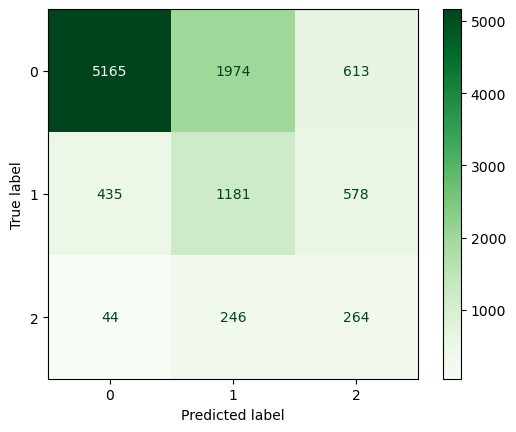

In [187]:
ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [180]:
confusion_matrix(y_test, preds)

array([[5462, 1747,  543],
       [ 522, 1121,  551],
       [  58,  237,  259]], dtype=int64)

In [181]:
three = confusion_matrix(y_test, preds)[2]
(three[2]+three[1]*.5)/sum(three)

0.6814079422382672

In [ ]:
#Let's try now via randomly sampling the 2 category from the start...

